# Analysing the Parties Press Release for 2019 Canadian Federal Election


**Packages Used:**

- Pandas
- NumPy
- Sklearn
- [NLTK](https://www.nltk.org/): a convenient Python library for natural language processing.
-------
This project has two goals: 
1. explore correlation and word visuzalition based on the press release.
2. predict the party based on the tone of the press release.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import re 
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

## Naive Bayes classifier

Naive Bayes classifier is built with the Bayes Theorem Assumption


-- In the training set we calculate 
<center>
    \begin{align}
    \\ P(X \cap Y) = P(X| Y=y) P(Y)
    \end{align}
</center>


- And based on Bays we also have:

<center>
    \begin{align}
    \\ P(X \cap Y) = P(Y│X=x) P(X)
    \end{align}
</center>

Which is what we apply in the testing set to predict the category.

-------------------------------------
With that our model recipe has to make the following calculations:

**Training set**

1. Calculate the frequency of each party press release in the training df
2. Count how many times each word happens per party



**Testing set**
1. Calculate the # of words in a press release.
2. Using the intersection function calculate the P(Y|X=x)




In [2]:
df = pd.read_csv('canada_parties_pr.csv')
df.head()

,party,url,content,date
0,conservative,https://www.conservative.ca/the-hon-andrew-sch...,"\r\nFOR IMMEDIATE RELEASE\r\nOttawa, ON – The ...",2019-07-11
1,conservative,https://www.conservative.ca/justin-trudeau-mus...,"\r\nFOR IMMEDIATE RELEASE\r\n\r\nTORONTO, ON\r...",2019-07-11
2,conservative,https://www.conservative.ca/justin-trudeaus-ba...,"\r\nFOR IMMEDIATE RELEASE\r\nOTTAWA, ON – Pier...",2019-05-28
3,conservative,https://www.conservative.ca/conservatives-to-s...,\r\nNew conservative government to extend EI p...,2019-10-15
4,conservative,https://www.conservative.ca/andrew-scheer-reve...,\r\nConservatives unveil fully costed platform...,2019-10-11


In [3]:
df['party'].value_counts()

liberal         200
conservative    185
NDP             117
Name: party, dtype: int64

In [4]:
df['party'].value_counts()

liberal         200
conservative    185
NDP             117
Name: party, dtype: int64

In [5]:
#define the stop words
stop_extra = ['*', '#', '?', '$', '!', '&',  '%', '\'','\'ll', '"','\'\'' '\'m', '\'re', '\'ve', '(', ')', '\'s', '-', '--']
stop = stopwords.words('english') + stop_extra

In [6]:
#function that tokenize a sentence and cleans up
def sentence_to_word(df, column_name, stop):
    
    #lower case
    df[column_name] = df[column_name].apply(lambda string: string.lower())
    df['words'] = df[column_name].apply(nltk.word_tokenize)
    df['words'] = df['words'].apply(lambda x: [item for item in x if item not in stop])
    df['words'] = df['words'].apply(lambda x: [item for item in x if item.isalpha()])
    
    return df

In [7]:
#enconde the labels
le = LabelEncoder()
enc = OneHotEncoder()
df['labels']=le.fit_transform(df[['party']])

**The Labels are**

In [8]:
df[['labels', 'party']].drop_duplicates(keep='last')

,labels,party
184,1,conservative
384,2,liberal
501,0,NDP


In [12]:
#separate test and training
y = df['labels']
X = df['content']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(f'test size: '{len(X_test)}' and training size: ')

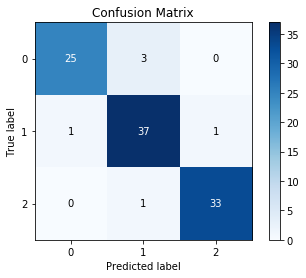

In [13]:
#vectorized the words in the keyword
vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train)
ndf = pd.SparseDataFrame(
    X_train_vectorized.toarray(), columns=vect.get_feature_names()
)

#apply pre made model
clfrNB = MultinomialNB(alpha=0.1)
clfrNB.fit(X_train_vectorized, y_train)
y_pred = clfrNB.predict(vect.transform(X_test))
skplt.metrics.plot_confusion_matrix(y_test, y_pred);


In [29]:
#tokenize the press release and lower case and remove stop words
training_set = pd.DataFrame(data = {'party': y_train, "content":X_train})
training_set = sentence_to_word(training_set, 'content', stop)

In [87]:
#counts the frequency
rows = list()
for row in training_set[['party', 'words']].iterrows():
    r = row[1]
    #print(r)
    for word in r.words:
        rows.append((r.party, word))
single_words = pd.DataFrame(rows, columns=['party', 'word'])
single_words['counter'] = 1



#count total words of party
single_words['n_parties']= single_words.groupby('party')['counter'].transform('sum')

#count the frequency of words
counts = single_words.groupby('word')\
    .agg({'counter':'sum'})\
    .rename(columns={'counter':'n_w'})
counts = counts.reset_index(level=['word'])

#counts the frequency of words by party
counts2 = single_words.groupby(['word', 'party'])\
    .agg({'counter':'sum'})\
    .rename(columns={'counter':'n_wp'})
counts2 = counts2.reset_index()

-> next steps 
the current code is not calculating the probability of not being in that category
I need to find a way to add the missing category in training set using the Laplace smoother. A good example is the word yazidis that has only one records when it should have had 3. 

The next step is make this into a function so I can apply into the news.

In [ ]:
contigence_table[contigence_table['word']=='yazidis']

In [88]:
#created the contigence table
contigence_table = pd.merge(single_words, counts, on=['word'])
contigence_table['n'] =len(contigence_table['word'])
contigence_table = contigence_table.drop_duplicates(keep='last')
contigence_table = pd.merge(contigence_table, counts2, on=['word', 'party'])
n_uniques = contigence_table['word'].nunique()
contigence_table['unique_words'] = n_uniques
contigence_table['prob_y'] = contigence_table['n_parties']/contigence_table['n']
#contigence_table['prob_x'] = (1 + contigence_table['n_w'])/contigence_table['n'] #+1 forlaplace smoother
#contigence_table['prob_xay'] = (1 + contigence_table['n_wp'])/contigence_table['n'] #+1 forlaplace smoother
contigence_table['prob_xgy'] = (1 + contigence_table['n_w'])/(contigence_table['unique_words']+contigence_table['n_parties']) #+1 forlaplace smoother
#contigence_table['prob_ygx'] = (1 + contigence_table['n_wp'])/contigence_table['n_parties'] #+1 forlaplace smoother

contigence_table.head()

,party,word,counter,n_parties,n_w,n,n_wp,unique_words,prob_y,prob_xgy
0,0,families,1,14427,247,66519,59,7679,0.216885,0.011219
1,1,families,1,25291,247,66519,75,7679,0.380207,0.007522
2,2,families,1,26801,247,66519,113,7679,0.402907,0.007193
3,0,go,1,14427,68,66519,12,7679,0.216885,0.003121
4,1,go,1,25291,68,66519,17,7679,0.380207,0.002093


In [89]:
party = contigence_table[['party', 'prob_y', 'n_parties', 'unique_words', ]].drop_duplicates(keep='last')


## Testing set
Now that we have the probabilities calculated, we can try to predict the party or the political view given the words used.


In [148]:
#Step 6 tokenize the keywords in the testing set
test_df = pd.DataFrame(data={'content': X_test, 'party_real': y_test})
test_df = sentence_to_word(test_df, 'content', stop)


rows = list()
for row in test_df[['content','party_real','words']].iterrows():
    r = row[1]
    #print(r)
    for word in r.words:
        rows.append((r.content, r.party_real, word))

test_df = pd.DataFrame(rows, columns=['content','party_real', 'word'])



#applies the Laplace smoother for the words that are not present in the training dataset
test_df = pd.merge(test_df, contigence_table[['party','word', 'prob_xgy']],  on=['word'], how='left')
test_df.rename(columns  = {"party": "party_training"},inplace = True) 


#matrix product to reproduce party  by row
product = pd.MultiIndex.from_product([test_df['word'], party['party']], names = ["word", "party_null"])
product = pd.DataFrame(index = product).reset_index()
product = product.drop_duplicates(keep='last')
test_df = pd.merge(product, test_df, on = ['word'])

#get the party unique_words, p_y and n_parties
test_df = pd.merge(party, test_df, left_on = ['party'], right_on =['party_null'])

test_df = test_df.sort_values(by=['content','word', 'party_training'] , ascending = [True, False, True])
#fills out the pred party for the words not present in the training dataset
test_df['prob_xgy'] = test_df['prob_xgy'].fillna(1/(test_df['unique_words']+test_df['n_parties']))
test_df['party_pred'] = np.where(test_df['party_training'].isnull(), test_df['party_null'], test_df['party_training'])
test_df = test_df[test_df['party']==test_df['party_pred']]
test_df = test_df[['content', 'word','party_real','party_pred', 'prob_xgy', 'prob_y']]


test_df = test_df.drop_duplicates(keep='last')

test_df.head()
test_df[test_df['word']=='yazidis'].head(10)


,content,word,party_real,party_pred,prob_xgy,prob_y
93987,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",yazidis,1,1.0,0.000061,0.380207


In [193]:
probability = pd.MultiIndex.from_product([x_test_prob['word'], y_prob['party']], names = ["word", "party"])
probability = pd.DataFrame(index = probability).reset_index()
probability = pd.merge(probability, x_test_prob, on = ['word'])
probability = pd.merge(probability, x_train, how='left', on = ['word', 'party'])
probability = pd.merge(probability, y_prob, how='inner', on = ['party'])

probability.head()

,word,party,prob_x,prob_xay,prob_xgy,prob_y,total_words_per_party
0,share,2,0.002915,0.003058,0.007388,0.413965,26801
1,ottawa,2,0.001700,0.002348,0.005671,0.413965,26801
2,justin,2,0.012025,0.011878,0.028693,0.413965,26801
3,trudeau,2,0.019981,0.020141,0.048655,0.413965,26801
4,leader,2,0.005284,0.005236,0.012649,0.413965,26801


In [194]:
#fill the nulls using the laplace smoother
probability['prob_xay'] = probability['prob_xay'].fillna(1/probability['total_words_per_party'])

In [219]:
test_df = pd.DataFrame(rows, columns=['content', 'word'])
test_df = pd.merge(test_df, probability, how = 'inner', on=['word'])

In [220]:
#now we merge back to the original testing dataframe
test_df['prob_ygx'] = test_df['prob_xay']/ test_df['prob_x']
test_df = test_df[test_df.columns.difference(['prob_x', 'prob_xgy', 'prob_y', 'total_words_per_party'])]
test_df.head()

,content,party,prob_xay,prob_ygx,word
0,"\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nottawa, o...",2,0.003058,1.049119,share
1,"\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nottawa, o...",0,0.003046,1.044917,share
2,"\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nottawa, o...",1,0.002850,0.977810,share
3,\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nst. john’...,2,0.003058,1.049119,share
4,\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nst. john’...,0,0.003046,1.044917,share


In [221]:
test_df =  test_df[['content','party', 'prob_xay']].groupby(['content', 'party']).prod()
test_df = test_df.reset_index()

#normalize
test_df['prob_ygx'] = (test_df['prob_xay']) / (test_df['prob_xay'].max() - test_df['prob_xay'].min())
test_df = test_df.sort_values(by=['content','prob_xay'] , ascending = [True, False])


#change the column party name to receive the real
test_df.rename(columns  = {"party": "party_pred"},inplace = True) 


#test_df = pd.merge(test_df, df, how='left', on=['content'])
test_df.head()


,content,party_pred,prob_xay,prob_ygx
0,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",0,0.0,0.0
1,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",1,0.0,0.0
2,"\r\n\r\njune 20, 2019 \r\n\r\n\r\nfor immediat...",2,0.0,0.0
3,\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nbrockvill...,0,0.0,0.0
4,\r\n\r\nshare\r\n\r\n\r\n\r\n\r\n\r\nbrockvill...,1,0.0,0.0


In [222]:
df.loc[103]

party                                           conservative
url        https://www.conservative.ca/conservatives-call...
content    \r\nfor immediate release\r\n \r\nottawa, on\r...
date                                              2019-07-26
labels                                                     1
Name: 103, dtype: object

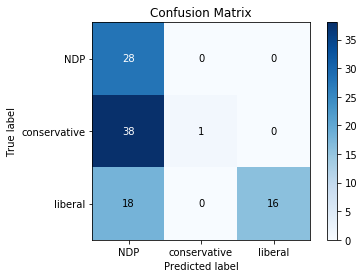

In [223]:
df['content'] = df['content'].apply(lambda string: string.lower())
test = pd.merge(test_df, df[['party', 'content']], how='inner', on=['content'])
test = test.drop_duplicates(keep='last')
test = test[['content', 'party_pred','party', 'prob_ygx']]
test = test.loc[test.groupby('content').prob_ygx.agg('idxmax')]
test['party_pred'] = test['party_pred'].replace({0:'NDP' , 1: 'conservative', 2:'liberal'})
skplt.metrics.plot_confusion_matrix(test['party'], test['party_pred']);


_Notebook by: Andresa de Andrade inspired by the work of François Maillet in the 2015 Federal election analysis._
